### Imports and Helper

In [1]:
import pandas as pd
import librosa as lr
import librosa.display as lrd
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.utils.data import Dataset
import math
import datetime

# Dataset

In [2]:
from librosa import util
from joblib import Parallel, delayed
from tqdm import tqdm

In [3]:
from customdataset import WindowedAudioDataset

In [4]:
audio_base_path = 'data/MEMD_audio/'
arousal_file = 'data/annotations/annotations averaged per song/dynamic (per second annotations)/arousal.csv'
valence_file = 'data/annotations/annotations averaged per song/dynamic (per second annotations)/valence.csv'
dataset_path = 'dataset.torchdata'

In [5]:
#deam_dataset = WindowedAudioDataset(arousal_file,
#                                    valence_file,
#                                    audio_base_path)

In [6]:
#deam_dataset.generate_x_y()

In [8]:
dataset = torch.load(dataset_path)

In [10]:
dataset.mode = 'energy-tempo'

In [12]:
test = dataset[0]

In [14]:
test[0][0].size()

torch.Size([500])

In [15]:
test[0][1].size()

torch.Size([500, 384])

# Model

In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler


In [18]:
batch_size = 128
validation_split = .2
shuffle_dataset = True
random_seed = 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [31]:
class TempogramNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.pool1 = nn.MaxPool2d(5)
        self.dropout2d1 = nn.Dropout2d(p=0.1, inplace=False)
        self.conv2 = nn.Conv2d(5, 5, 5)
        self.pool2 = nn.MaxPool2d(5)
        self.fc1 = nn.Linear(1330, 120)
        self.dropout1 = nn.Dropout(p=0.1, inplace=False)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = x[:, None, :, :]
        x = self.dropout2d1(self.pool1(F.relu(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout1(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [32]:
net = TempogramNet()

In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

In [34]:
from sklearn.metrics import r2_score

In [42]:
for test_batch, test_y in validation_loader:
    print(test_batch[1].size())
    break

torch.Size([128, 500, 384])


In [35]:
net((dataset[0][0][1])[None, :, :])

tensor([[ 0.0197, -0.0550]], grad_fn=<AddmmBackward>)

In [43]:
val_loss = []
train_loss = []

for epoch in tqdm(range(15)):

    with torch.set_grad_enabled(False):
        sum = 0.0
        sum_r2 = 0.0
        for test_batch, test_y in validation_loader:
            pred = net(test_batch[1])
            loss = criterion(pred, test_y)
            sum_r2 += r2_score(test_y, pred)
            sum += loss.item()
        val_loss.append([float(epoch), sum / len(validation_loader), sum_r2 / len(validation_loader)])

    i = 0
    for local_batch, local_labels in train_loader:
        optimizer.zero_grad()

        # prediction for training and validation set
        pred = net(local_batch[1])
        # computing the training and validation loss
        loss_train = criterion(pred, local_labels)
        loss_train.backward()
        optimizer.step()

        i += 1
        train_loss.append([float(epoch + i/len(train_loader)), loss_train.item()])

KeyboardInterrupt: 

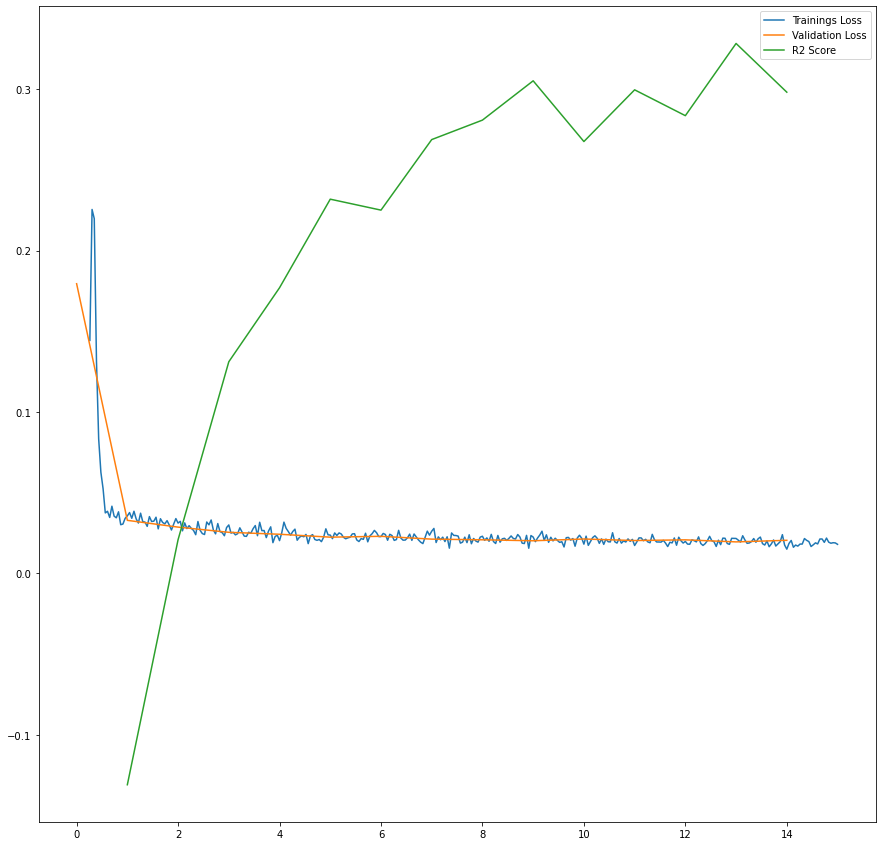

In [87]:
val_loss = np.array(val_loss)
train_loss = np.array(train_loss)

fig, ax = plt.subplots(figsize=(15,15))
ax.plot(train_loss[5:, 0], train_loss[5:, 1], label='Trainings Loss')
ax.plot(val_loss[:, 0], val_loss[:, 1], label='Validation Loss')
ax.plot(val_loss[1:, 0], val_loss[1:, 2], label='R2 Score')
ax.legend()